In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec  # Import for custom grid layout
from scipy import stats
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import resample
from joblib import Parallel, delayed
import plotly.graph_objects as go
import plotly.express as px

from dPCA import dPCA

from notebooks.imports import *
from config import dir_config, main_config, ephys_config
from src.utils import pmf_utils, plot_utils, ephys_utils



In [4]:
compiled_dir = Path(dir_config.data.compiled)
processed_dir = Path(dir_config.data.processed)

## Utils

In [ ]:
def classification(class_means, test):
    Q = class_means.shape[0]
    T = class_means.shape[1]
    performance = np.zeros(T)
    distance = 0.

    # classify every data point in test according to nearest class mean
    for t in range(T):
        for p in range(Q):
            argmin = 0
            distance = abs(class_means[argmin,t] - test[p,t])
            
            # find closest class mean
            for q in range(1,Q):
                if abs(class_means[q,t] - test[p,t]) < distance:
                    distance = abs(class_means[q,t] - test[p,t])
                    argmin = q

            # add 1 if class is correct
            if argmin == p:
                performance[t] += 1.

        performance[t] /= Q

    return performance

def denoise_mask(mask, n_consecutive):
    subseq = 0
    N = mask.shape[0]
        
    for n in range(N):
        if mask[n] == 1:
            subseq += 1
        else:
            if subseq < n_consecutive:
                for k in range(n-subseq,n):
                    mask[k] = 0
                    
    return mask

def flat2d(A):
        ''' Flattens all but the first axis of an ndarray, returns view. '''
        return A.reshape((A.shape[0],-1))

def dpca_transform(dpca, X):    
    X = X - np.nanmean(X.reshape((X.shape[0],-1)),1).reshape((X.shape[0],) + (len(X.shape)-1)*(1,))
    total_variance = np.sum((X - np.nanmean(X))**2)
    def marginal_variances(marginal):
        ''' Computes the relative variance explained of each component
            within a marginalization
        '''
        D, Xr = dpca.D[marginal], X.reshape((X.shape[0],-1))
        return [np.sum(np.dot(D[:,k], Xr)**2) / total_variance for k in range(D.shape[1])]
    
    X_transformed = {}
    dpca.explained_variance_ratio_ = {}
    for key in list(dpca.marginalizations.keys()):
        X_transformed[key] = np.dot(dpca.D[key].T, X.reshape((X.shape[0],-1))).reshape((dpca.D[key].shape[1],) + X.shape[1:])
        dpca.explained_variance_ratio_[key] = marginal_variances(key)
    return dpca, X_transformed

def create_dpca_matrix(sessions, condition_dict, session_neuron_ids, biased_state_trial_info, unbiased_state_trial_info):
    n_neurons = len(session_neuron_ids)
    n_states = len(condition_dict["state_values"])
    n_coherences = len(condition_dict["coherences"])
    n_choices = len(condition_dict["choices"])
    dPCA_averaged_data = {event: np.full([n_neurons, n_states, n_coherences, n_choices, 
                                 ephys_config["alignment_settings_GP"][event]["end_time_ms"] -ephys_config["alignment_settings_GP"][event]["start_time_ms"]+1], np.nan) 
                                 for event in ephys_config["alignment_settings_GP"].keys()}
    dPCA_trial_wise_data = {event: np.full([500, n_neurons, n_states, n_coherences, n_choices, 
                                 ephys_config["alignment_settings_GP"][event]["end_time_ms"] -ephys_config["alignment_settings_GP"][event]["start_time_ms"]+1], np.nan) 
                                 for event in ephys_config["alignment_settings_GP"].keys()}
    
    for alignment in ephys_config["alignment_settings_GP"].keys():
        for session_id in sessions:
            # get neurons in this session
            neuron_ids = neuron_metadata.neuron_id[neuron_metadata.session_id == session_id].values
            # extract trial numbers for each condition
            for state_idx, state in enumerate(condition_dict["state_values"]):
                if state == "biased":
                    trial_info = biased_state_trial_info
                elif state == "unbiased":
                    trial_info = unbiased_state_trial_info
                for coherence_idx, coherence in enumerate(condition_dict["coherences"]):
                    for choice_idx, choice in enumerate(condition_dict["choices"]):
                        trials = ephys_utils.get_trial_num(trial_info[session_id], coherence=coherence, choice=choice_idx, outcome=1)

                        for neuron_id in neuron_ids:
                            trial_wise_data = ephys_utils.get_neural_data_from_trial_num(ephys[alignment][neuron_id], trials, type="convolved_spike_trains")                            
                            if trial_wise_data.shape[0] == 0:
                                print(f"No trials found in Session: {session_id}, State: {state}, Neuron: {neuron_id}, condition: {coherence, choice}")
                                continue
                            averaged_data = np.nanmean(trial_wise_data, axis=0)
                              
                            if alignment == "stimulus_onset":
                                non_nan_timepoint = np.where(np.sum(np.isnan(trial_wise_data), axis=0)/len(trials) <= 0.7)[0]
                                averaged_data = averaged_data[:non_nan_timepoint[-1] + 1]
                                dPCA_averaged_data[alignment][np.where(session_neuron_ids == neuron_id)[0], state_idx, coherence_idx, choice_idx, 0:len(averaged_data)] = averaged_data
                                # indices = np.where(np.isin(trial_info[session_id]["trial_num"], trials))[0]
                                # median_reaction_time = np.nanmedian(trial_info[session_id]["reaction_time"].iloc[indices])
                                # averaged_data = averaged_data[:int(median_reaction_time-ephys_config["alignment_settings_GP"][alignment]["start_time_ms"])+1]
                            elif alignment == "response_onset":
                                non_nan_timepoint = np.where(np.sum(np.isnan(trial_wise_data), axis=0)/len(trials) <= 0.7)[0]
                                averaged_data = averaged_data[non_nan_timepoint[0]:]
                                dPCA_averaged_data[alignment][np.where(session_neuron_ids == neuron_id)[0], state_idx, coherence_idx, choice_idx, -len(averaged_data):] = averaged_data
                            else:
                                dPCA_averaged_data[alignment][np.where(session_neuron_ids == neuron_id)[0], state_idx, coherence_idx, choice_idx, :] = averaged_data

                            dPCA_trial_wise_data[alignment][:trial_wise_data.shape[0], np.where(session_neuron_ids == neuron_id)[0], state_idx, coherence_idx, choice_idx, :] = np.expand_dims(trial_wise_data, axis=1)
                                
    return dPCA_averaged_data, dPCA_trial_wise_data

def dpca_train_test_split(dpca,X,trialX,N_samples=None,sample_ax=0):
    protect = dpca.protect
    n_unprotect = len(X.shape) - len(protect) if protect is not None else len(X.shape)
    n_protect   = len(protect) if protect is not None else 0

    if sample_ax != 0:
        raise NotImplemented('The sample axis needs to come first.')

    # test if all protected axes lie at the end
    protected = dpca._check_protected(trialX,protect)

    # reorder matrix to protect certain axis (for speedup)
    if ~protected:
        # turn crossval_protect into index listX
        axes = [dpca.labels.index(ax) + 2 for ax in protect]

        # reorder matrix
        trialX = dpca._roll_back(trialX,axes)
        X = np.squeeze(dpca._roll_back(X[None,...],axes))

    # compute number of samples in each condition
    if N_samples is None:
        N_samples = dpca._get_n_samples(trialX,protect=dpca.protect)

    # get random indices
    idx = (np.random.rand(*N_samples.shape)*N_samples).astype(int)

    # select values
    blindX = np.empty(trialX.shape[1:])

    # iterate over multi_index
    it = np.nditer(np.empty(N_samples.shape), flags=['multi_index'])

    while not it.finished:
        blindX[it.multi_index + (np.s_[:],)*n_protect] = trialX[(idx[it.multi_index],) + it.multi_index + (np.s_[:],)*n_protect]
        it.iternext()

    # compute trainX
    trainX = (X * (N_samples / (N_samples - 1))[(np.s_[:],) * n_unprotect + (None,) * n_protect] 
          - np.where(np.isnan(blindX), X, blindX) / (N_samples - 1)[(np.s_[:],) * n_unprotect + (None,) * n_protect])

    # trainX = (X*(N_samples/(N_samples-1))[(np.s_[:],)*n_unprotect + (None,)*n_protect] - blindX/(N_samples-1)[(np.s_[:],)*n_unprotect + (None,)*n_protect])

    # inverse rolled axis in blindX
    if ~protected:
        blindX = dpca._roll_back(blindX[...,None],axes,invert=True)[...,0]
        trainX = dpca._roll_back(trainX[...,None],axes,invert=True)[...,0]

    # remean datasets (both equally)
    trainX -= np.nanmean(flat2d(trainX),1)[(np.s_[:],) + (None,)*(len(X.shape)-1)]
    blindX -= np.nanmean(flat2d(blindX),1)[(np.s_[:],) + (None,)*(len(X.shape)-1)]

    return trainX, blindX

def compute_mean_score(dpca, X, trialX, n_splits, keys, axis=None):
    K = X.shape[-1]

    if type(dpca.n_components) == int:
        scores = {key : np.empty((dpca.n_components, n_splits, K)) for key in keys}
    else:
        scores = {key : np.empty((dpca.n_components[key], n_splits, K)) for key in keys}

    for shuffle in range(n_splits):
        print('.', end=' ')

        # do train-validation split
        trainX, validX = dpca_train_test_split(dpca,X,trialX)
        # fit a dPCA model to training data & transform validation data
        dpca.fit(trainX)
        dpca, trainZ = dpca_transform(dpca, trainX)
        dpca, validZ = dpca_transform(dpca, validX)

        # reshape data to match Cython input
        for key in keys:
            ncomps = dpca.n_components if type(dpca.n_components) == int else dpca.n_components[key]

            # mean over all axis not in key
            axset = dpca.marginalizations[key]
            axset = axset if type(axset) == set else set.union(*axset)
            if axis is None:
                axes = set(range(len(X.shape)-1)) - axset
            else:
                axes = set(range(len(X.shape)-1)) - axset - {len(X.shape)-2}
            for ax in list(axes)[::-1]:
                trainZ[key] = np.nanmean(trainZ[key],axis=ax+1)
                validZ[key] = np.nanmean(validZ[key],axis=ax+1)

            # reshape
            if (len(X.shape)-2 in axset) or (axis):
                trainZ[key] = trainZ[key].reshape((ncomps,-1,K))
                validZ[key] = validZ[key].reshape((ncomps,-1,K))
            else:
                trainZ[key] = trainZ[key].reshape((ncomps,-1,1))
                validZ[key] = validZ[key].reshape((ncomps,-1,1))

        # compute classification score
        for key in keys:
            ncomps = dpca.n_components if type(dpca.n_components) == int else dpca.n_components[key]
            for comp in range(ncomps):
                scores[key][comp, shuffle] = classification(trainZ[key][comp],validZ[key][comp])

    for key in keys:
        scores[key] = np.nanmean(scores[key], axis=1)
                
    return scores

def dpca_significance_analysis(dpca, X, trialX, n_shuffles=100, n_splits=100, n_consecutive=10, axis=None, full=False):

    if dpca.opt_regularizer_flag:
        print("Regularization not optimized yet; start optimization now.")
        dpca._optimize_regularization(X,trialX)

    keys = list(dpca.marginalizations.keys())
    keys.remove(dpca.labels[-1])

    # shuffling is in-place, so we need to copy the data
    trialX_shuffled = trialX.copy()

    # compute score of original data
    print("Compute score of data: ", end=' ')
    true_score = compute_mean_score(dpca, X, trialX, n_splits, keys, axis=axis)
    print("Finished.")

    # data collection
    scores = {key : [] for key in keys}

    # iterate over shuffles
    for it in range(n_shuffles):
        print("\rCompute score of shuffled data: ", str(it), "/", str(n_shuffles), end=' ')
        trialX_shuffled = dpca.shuffle_labels(trialX_shuffled)
        # mean trial-by-trial data
        X_shuffled = np.nanmean(trialX_shuffled,axis=0)
        # remove any timepoints with nan in X
        no_any_nan_mask = ~np.any(np.isnan(X_shuffled), axis=(0, 1, 2, 3))
        X_shuffled = X_shuffled[...,no_any_nan_mask]
        trialX_shuffled = trialX_shuffled[...,no_any_nan_mask]

        score = compute_mean_score(dpca,X_shuffled,trialX_shuffled,n_splits,keys,axis=axis)

        for key in keys:
            scores[key].append(score[key])

    # binary mask, if data score is above maximum shuffled score make true
    masks = {}
    for key in keys:
        maxscore = np.amax(np.dstack(scores[key]),-1)
        masks[key] = true_score[key] > maxscore

    if n_consecutive > 1:
        for key in keys:
            mask = masks[key]

            for k in range(mask.shape[0]):
                masks[key][k,:] = denoise_mask(masks[key][k].astype(np.int32),n_consecutive)

    if full:
        return masks, true_score, scores
    else:
        return masks
    
def dpca_shuffle(dpca, trialX, n_shuffles = 10):
    shuffled_Z = {} 
    for n_shuffle in range(n_shuffles):
        # shuffle labels
        trialX = dpca.shuffle_labels(trialX)
        # mean trial-by-trial data
        X = np.nanmean(trialX,axis=0)
        # remove any timepoints with nan in X
        no_any_nan_mask = ~np.any(np.isnan(X), axis=(0, 1, 2, 3))
        X = X[...,no_any_nan_mask]
        trialX = trialX[...,no_any_nan_mask]
        dpca.fit(X,trialX)
        _, shuffled_Z[n_shuffle] = dpca_transform(dpca, X)
    min_timepoints = np.min([shuffled_Z[n_shuffle]['t'].shape[4] for n_shuffle in range(n_shuffles)])
    mean_shuffled_Z = {key:[] for key in dpca.explained_variance_ratio_}
    for key in dpca.explained_variance_ratio_:
        mean_shuffled_Z[key] = np.mean(np.array([shuffled_Z[n_shuffle][key][...,0:min_timepoints] for n_shuffle in range(n_shuffles)]), axis=0)

    return shuffled_Z, mean_shuffled_Z
    


## Load Data

In [6]:
session_to_exclude = ["210210_GP_JP","241209_GP_TZ"]

session_metadata = pd.read_csv(Path(compiled_dir, 'sessions_metadata.csv'))
session_metadata = session_metadata[~np.isin(session_metadata["session_id"],session_to_exclude)] 

neuron_metadata = pd.read_csv(Path(compiled_dir, 'neuron_metadata.csv'))
neuron_metadata = neuron_metadata[~np.isin(neuron_metadata["session_id"],session_to_exclude)]

with open(Path(processed_dir, f'glm_hmm_all_trials_prior_based_initialization_final.pkl'), 'rb') as f:
    glm_hmm = pickle.load(f)

with open(Path(processed_dir, f'ephys_neuron_wise.pkl'), 'rb') as f:
    ephys = pickle.load(f)

## Extract biased and unbiased states, toRF and awayRF prior sessions

In [7]:
toRF_sessions = session_metadata["session_id"][session_metadata.prior_direction == "toRF"]
awayRF_sessions = session_metadata["session_id"][session_metadata.prior_direction == "awayRF"]

# extract neuron_id for each toRF session
toRF_neuron_ids = np.array([])
for session_id in toRF_sessions:
    neuron_ids = neuron_metadata.neuron_id[neuron_metadata.session_id == session_id].values
    toRF_neuron_ids = np.append(toRF_neuron_ids,neuron_ids)

# extract neuron_id for each awayRF session
awayRF_neuron_ids = np.array([])
for session_id in awayRF_sessions:
    neuron_ids = neuron_metadata.neuron_id[neuron_metadata.session_id == session_id].values
    awayRF_neuron_ids = np.append(awayRF_neuron_ids,neuron_ids)

In [8]:
state_occupancy = {}
biased_state_trial_info = {}
unbiased_state_trial_info = {}
for idx_session, session_id in enumerate(glm_hmm["session_wise"]["data"]):
    model = glm_hmm["session_wise"]["models"][session_id]
    choices = glm_hmm["session_wise"]["data"][session_id]["choices"].values.reshape(-1, 1)
    input = np.array(glm_hmm["session_wise"]["data"][session_id][["normalized_stimulus","bias","previous_choice","previous_target"]])
    if glm_hmm["session_wise"]["data"][session_id]["mask"] is None:
        mask = None
    else:
        mask = glm_hmm["session_wise"]["data"][session_id]["mask"]
    mask = np.ones_like(choices, dtype=bool) if mask is None else mask

    posterior_probs = model.expected_states(data=choices, input=input, mask=np.array(mask).reshape(-1,1))[0]
    biased_idx = (posterior_probs[:, 0] > 0.5) & np.array(mask)
    unbiased_idx = (posterior_probs[:, 1] > 0.5) & np.array(mask)
    state_occupancy[session_id] = {
        "biased_state_trials": glm_hmm["session_wise"]["data"][session_id]["trial_num"][biased_idx],
        "unbiased_state_trials": glm_hmm["session_wise"]["data"][session_id]["trial_num"][unbiased_idx]}
    
    biased_state_trials = state_occupancy[session_id]["biased_state_trials"]
    biased_state_trial_info[session_id] = glm_hmm["session_wise"]["data"][session_id].loc[np.isin(glm_hmm["session_wise"]["data"][session_id]["trial_num"], biased_state_trials)]
    unbiased_state_trials = state_occupancy[session_id]["unbiased_state_trials"]
    unbiased_state_trial_info[session_id] = glm_hmm["session_wise"]["data"][session_id].loc[np.isin(glm_hmm["session_wise"]["data"][session_id]["trial_num"], unbiased_state_trials)]



## dPCA

### Prepare trial-averaged data and trial-wise data

In [9]:
condition_dict = {"state_values": ["biased", "unbiased"],
        "coherences": [0, 0.06, 0.2, 0.5],
        "choices": ["awayRF", "toRF"],
        }

In [71]:
dPCA_averaged_data, dPCA_trial_wise_data = create_dpca_matrix(toRF_sessions, condition_dict, toRF_neuron_ids, biased_state_trial_info, unbiased_state_trial_info)
dPCA_averaged_full_data = dPCA_averaged_data.copy() 
dPCA_trial_wise_full_data = dPCA_trial_wise_data.copy()

for alignment in ephys_config["alignment_settings_GP"].keys():
    # remove timepoints with any nan in average data to fit with dpca
    no_any_nan_mask = ~np.any(np.isnan(dPCA_averaged_data[alignment]), axis=(0, 1, 2, 3))
    dPCA_averaged_data[alignment] = dPCA_averaged_data[alignment][..., no_any_nan_mask]
    dPCA_trial_wise_data[alignment] = dPCA_trial_wise_data[alignment][..., no_any_nan_mask]
    
    # remove timepoints with all nans in full data
    # used for shuffling
    no_all_nan_mask = ~np.all(np.isnan(dPCA_averaged_full_data[alignment]), axis=(0, 1, 2, 3))
    dPCA_averaged_full_data[alignment] = dPCA_averaged_full_data[alignment][..., no_all_nan_mask]
    dPCA_trial_wise_full_data[alignment] = dPCA_trial_wise_full_data[alignment][...,no_all_nan_mask]
    
    # remove nan trials in trial-wsie data(including full data)
    nonnan_trial_mask = ~np.all(np.isnan(dPCA_trial_wise_data[alignment]), axis=(1, 2, 3, 4, 5))
    dPCA_trial_wise_data[alignment] = dPCA_trial_wise_data[alignment][nonnan_trial_mask,...]
    dPCA_trial_wise_full_data[alignment] = dPCA_trial_wise_full_data[alignment][nonnan_trial_mask,...]
    

    print(dPCA_averaged_data[alignment].shape)
    print(dPCA_trial_wise_data[alignment].shape)
    print(dPCA_averaged_full_data[alignment].shape)
    print(dPCA_trial_wise_full_data[alignment].shape)
    

(86, 2, 4, 2, 501)
(174, 86, 2, 4, 2, 501)
(86, 2, 4, 2, 501)
(174, 86, 2, 4, 2, 501)
(86, 2, 4, 2, 356)
(174, 86, 2, 4, 2, 356)
(86, 2, 4, 2, 901)
(174, 86, 2, 4, 2, 901)
(86, 2, 4, 2, 307)
(174, 86, 2, 4, 2, 307)
(86, 2, 4, 2, 351)
(174, 86, 2, 4, 2, 351)


#### dpca fit

In [72]:
n_components = 3
dpca_toRF_sessions = {alignment:{} for alignment in ephys_config["alignment_settings_GP"]}

for alignment in ephys_config["alignment_settings_GP"]:
    dpca = dPCA.dPCA(n_components=n_components, labels='bsct',regularizer=0) # 4 features: state bias b, stimulus s, choice c, timepoint t
    dpca.protect = ['t']

    dpca.fit(dPCA_averaged_data[alignment], dPCA_trial_wise_data[alignment])

    X=dPCA_averaged_data[alignment]
    # X = dPCA_averaged_full_data[alignment]
    dpca, Z = dpca_transform(dpca, X)
    dpca_toRF_sessions[alignment]["model"] = dpca
    dpca_toRF_sessions[alignment]["transformed_data"] = Z

#### plot average

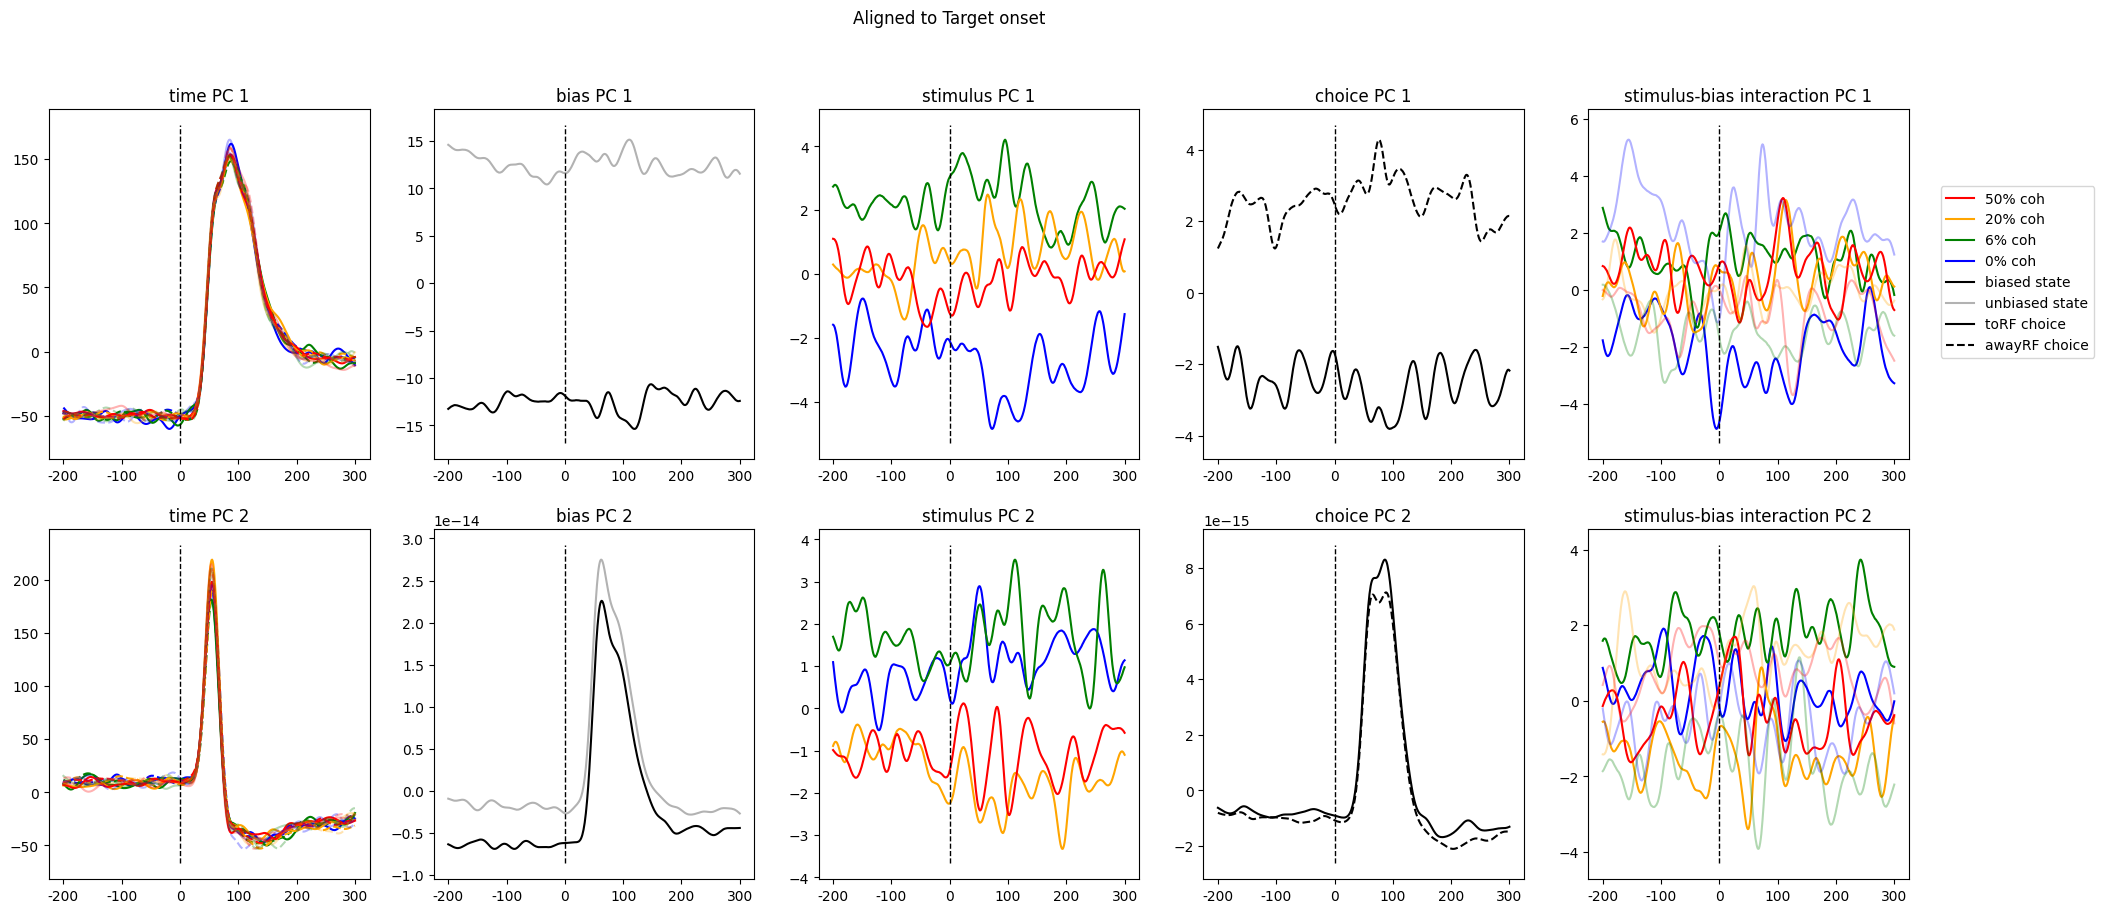

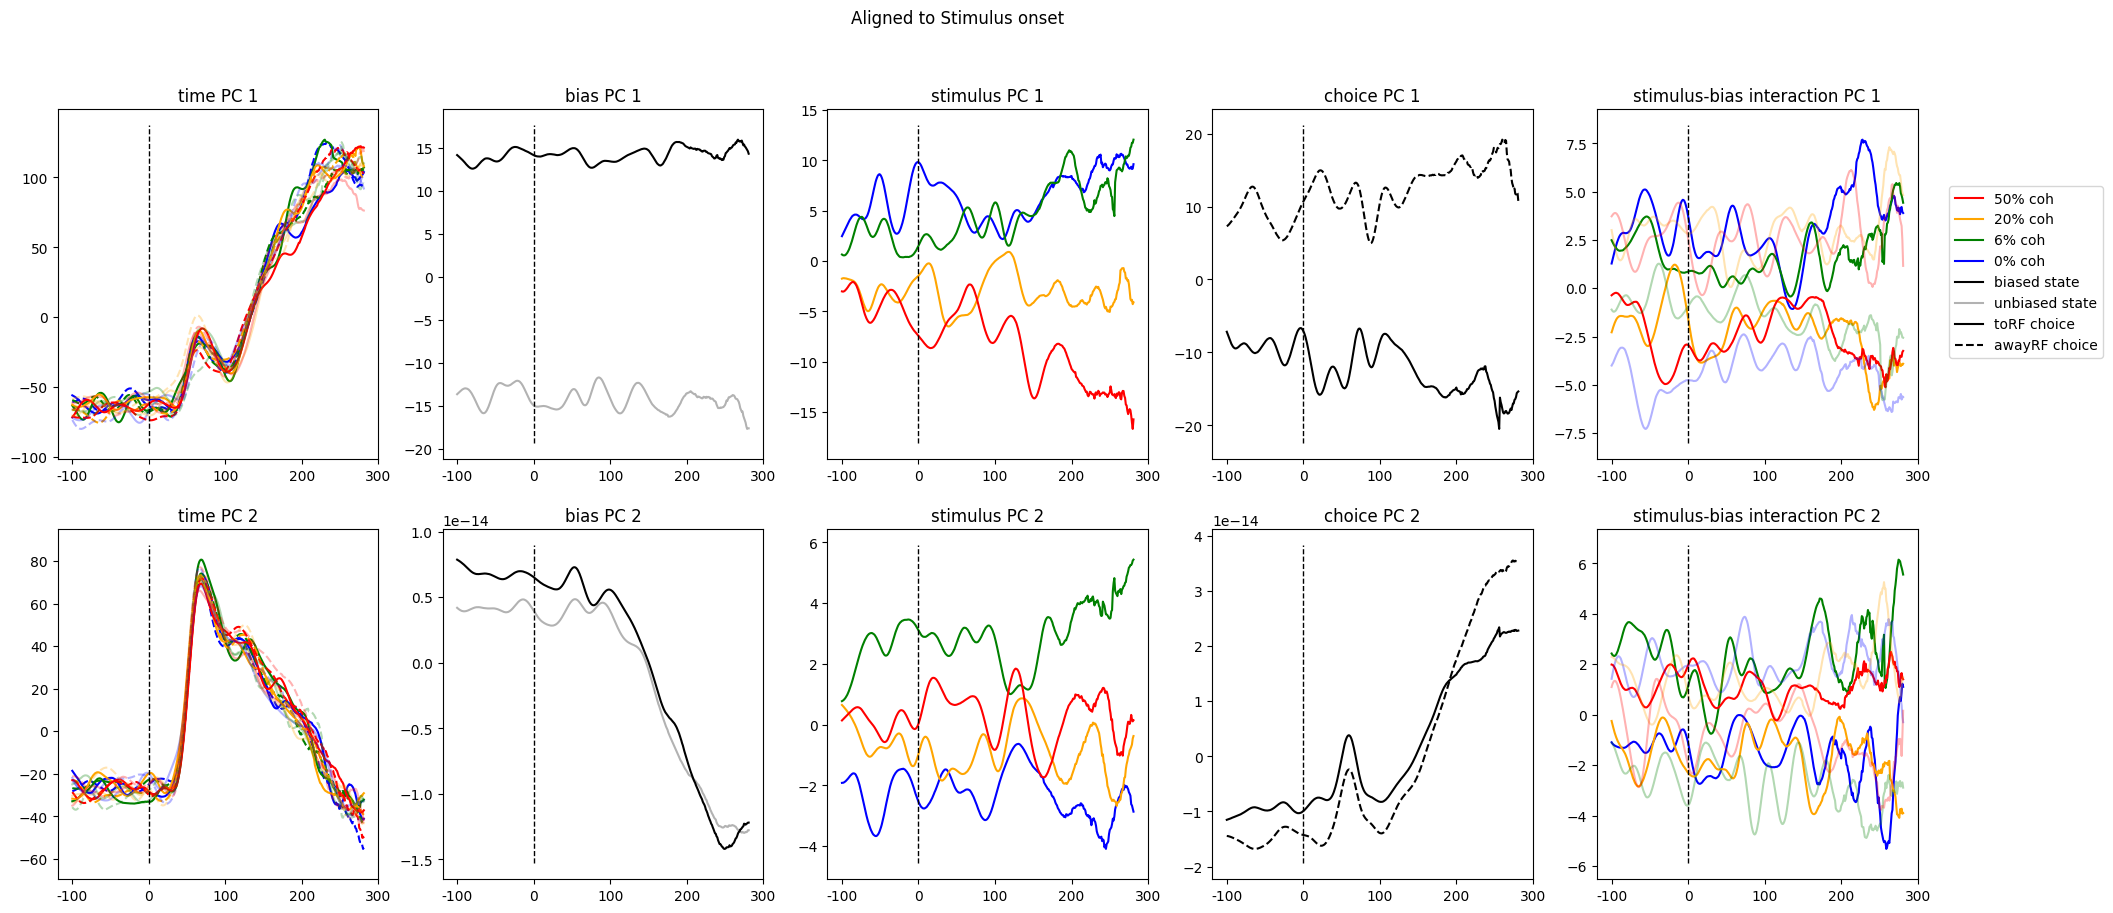

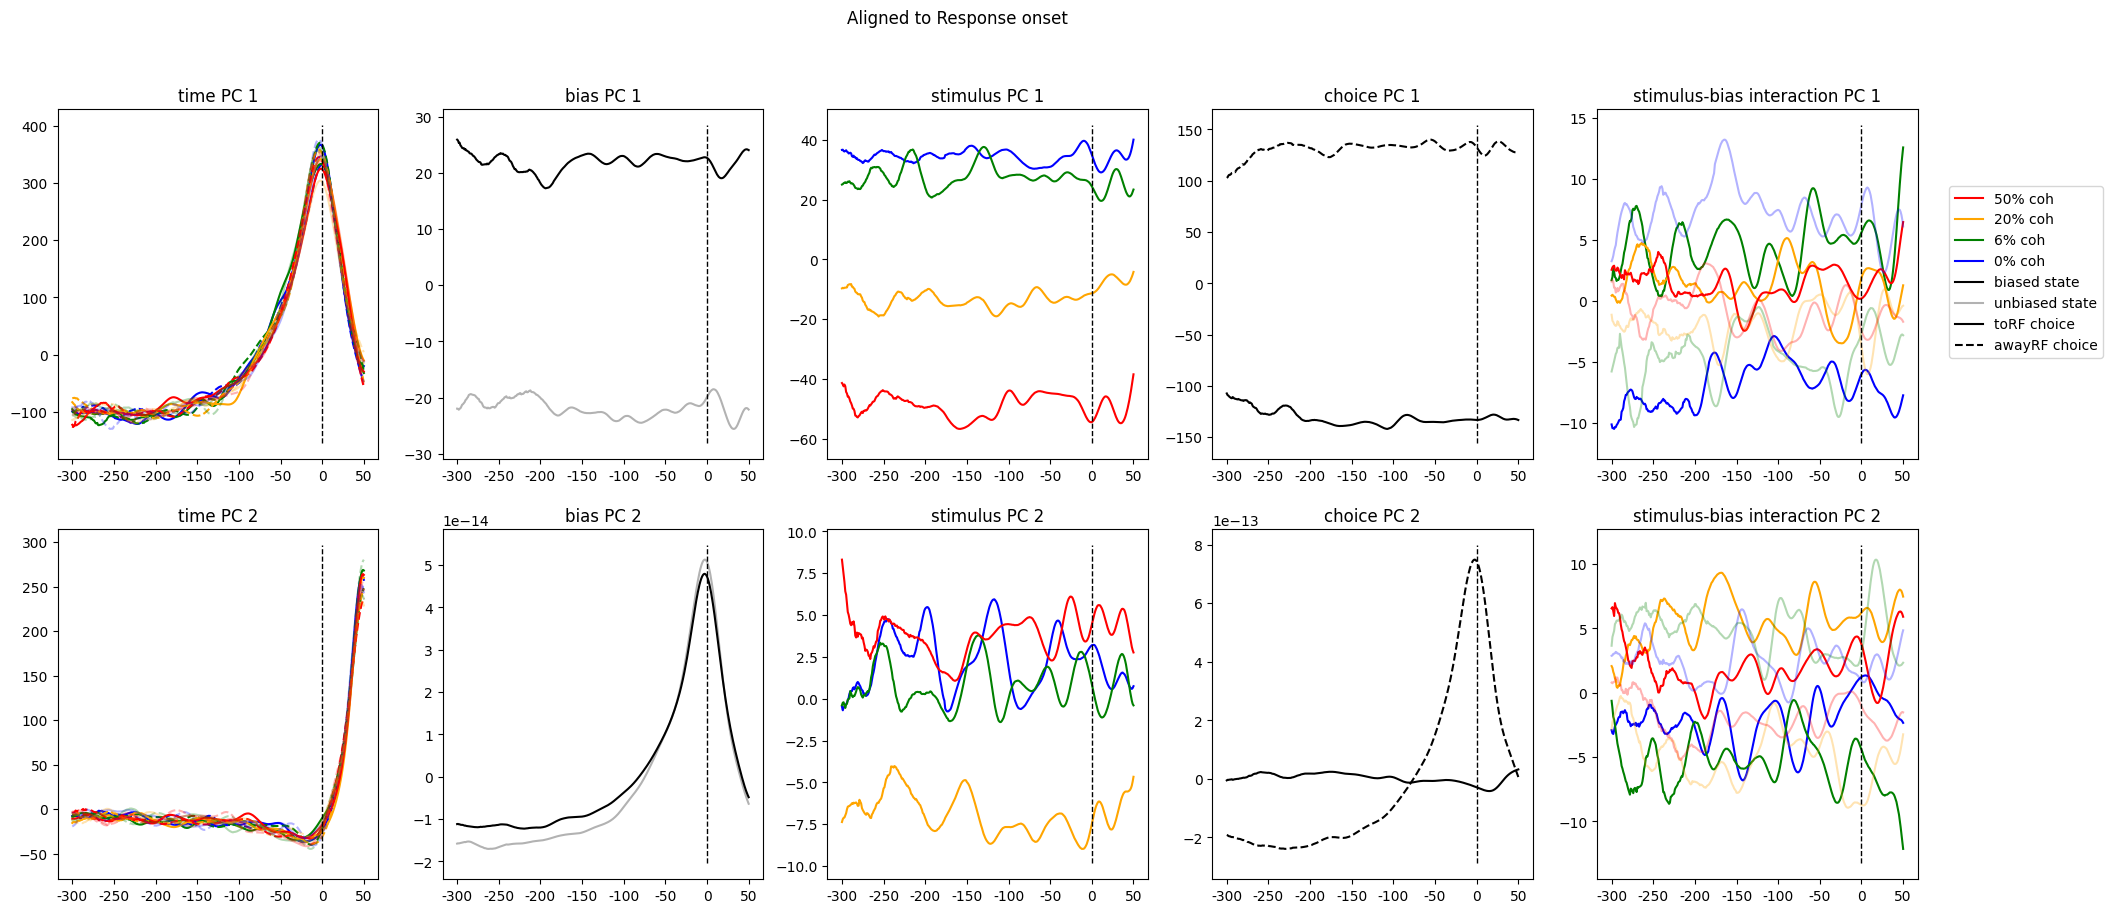

In [114]:
plot_params = {"color":{0:"blue",1:"green",2:"orange",3:"red"},
               "lw":{0:2, 1:1},
               "linestyle":{0:"-",1:"--"},
               "opacity":{0:1, 1:0.3}}

dpca_toRF_sessions = {}

for alignment in ephys_config["alignment_settings_GP"].keys():
    dpca = dPCA.dPCA(labels='bsct',regularizer=0) # 4 features: state bias b, stimulus s, choice c, timepoint t
    dpca.protect = ['t']

    dpca.fit(dPCA_averaged_data[alignment], dPCA_trial_wise_data[alignment])

    X=dPCA_averaged_data[alignment]
    # X = dPCA_averaged_full_data[alignment]
    dpca, Z = dpca_transform(dpca, X)
    dpca_toRF_sessions[alignment] = dpca

    alignment_dict = ephys_config["alignment_settings_GP"]
    time = np.arange(X.shape[-1])
    step = 50 if alignment == "response_onset" else 100


    # plt.figure(figsize=(24,10))
    plt.figure(figsize=(24,10))

    for PC_num in range(2):
        plt.subplot(2, 5, PC_num*5+1)

        for b in range(2):
            for s in range(4):
                for c in range(2):
                    plt.plot(time, Z['t'][PC_num, b, s ,c,:], color=plot_params["color"][s], alpha=plot_params["opacity"][b], linestyle=plot_params["linestyle"][c])
        plt.xticks(ticks=np.arange(0, alignment_dict[alignment]["end_time_ms"] - alignment_dict[alignment]["start_time_ms"] + 1, step),
                labels=np.arange(alignment_dict[alignment]["start_time_ms"], alignment_dict[alignment]["end_time_ms"]+ 1, step))
        ylim = plt.ylim()
        plt.vlines(-alignment_dict[alignment]["start_time_ms"], ylim[0], ylim[1], color="black", linestyle="--", linewidth=1)
        plt.title(f"time PC {PC_num+1}")


        plt.subplot(2, 5, PC_num*5+2)

        for b in range(2):        
            plt.plot(time, np.mean(Z['b'][PC_num, b,:,:,:], axis=(0, 1)), color='k', alpha=plot_params["opacity"][b], linestyle=plot_params["linestyle"][0])
        plt.title(f"bias PC {PC_num+1}")
        plt.xticks(ticks=np.arange(0, alignment_dict[alignment]["end_time_ms"] - alignment_dict[alignment]["start_time_ms"] + 1, step),
                labels=np.arange(alignment_dict[alignment]["start_time_ms"], alignment_dict[alignment]["end_time_ms"]+ 1, step))
        ylim = plt.ylim()
        plt.vlines(-alignment_dict[alignment]["start_time_ms"], ylim[0], ylim[1], color="black", linestyle="--", linewidth=1)

        plt.subplot(2, 5, PC_num*5+3)
        for s in range(4):
            plt.plot(time, np.mean(Z['s'][PC_num, :, s ,:,:], axis=(0, 1)), color=plot_params["color"][s], alpha=plot_params["opacity"][0], linestyle=plot_params["linestyle"][0])
        plt.title(f"stimulus PC {PC_num+1}")
        plt.xticks(ticks=np.arange(0, alignment_dict[alignment]["end_time_ms"] - alignment_dict[alignment]["start_time_ms"] + 1, step),
                labels=np.arange(alignment_dict[alignment]["start_time_ms"], alignment_dict[alignment]["end_time_ms"]+ 1, step))
        ylim = plt.ylim()
        plt.vlines(-alignment_dict[alignment]["start_time_ms"], ylim[0], ylim[1], color="black", linestyle="--", linewidth=1)

        plt.subplot(2, 5, PC_num*5+4)
        for c in range(2):
            plt.plot(time, np.mean(Z['c'][PC_num, :, : ,c,:], axis=(0, 1)), color='k', alpha=plot_params["opacity"][0], linestyle=plot_params["linestyle"][c])
        plt.title(f"choice PC {PC_num+1}")
        plt.xticks(ticks=np.arange(0, alignment_dict[alignment]["end_time_ms"] - alignment_dict[alignment]["start_time_ms"] + 1, step),
                labels=np.arange(alignment_dict[alignment]["start_time_ms"], alignment_dict[alignment]["end_time_ms"]+ 1, step))
        ylim = plt.ylim()
        plt.vlines(-alignment_dict[alignment]["start_time_ms"], ylim[0], ylim[1], color="black", linestyle="--", linewidth=1)

        plt.subplot(2, 5, PC_num*5+5)
        for b in range(2):
            for s in range(4):
                plt.plot(time, np.mean(Z['bs'][PC_num, b, s ,:,:],axis=0), color=plot_params["color"][s], alpha=plot_params["opacity"][b], linestyle=plot_params["linestyle"][0])
        plt.title(f"stimulus-bias interaction PC {PC_num+1}")
        plt.xticks(ticks=np.arange(0, alignment_dict[alignment]["end_time_ms"] - alignment_dict[alignment]["start_time_ms"] + 1, step),
                labels=np.arange(alignment_dict[alignment]["start_time_ms"], alignment_dict[alignment]["end_time_ms"]+ 1, step))
        ylim = plt.ylim()
        plt.vlines(-alignment_dict[alignment]["start_time_ms"], ylim[0], ylim[1], color="black", linestyle="--", linewidth=1)



    plt.plot([],[], color="red", label="50% coh")
    plt.plot([],[], color="orange", label="20% coh")
    plt.plot([],[], color="green", label="6% coh")
    plt.plot([],[], color="blue", label="0% coh")
    plt.plot([],[], color='k', alpha=1, label="biased state")
    plt.plot([],[], color='k', alpha=0.3, label="unbiased state")
    plt.plot([],[], color='k', linestyle="-", label="toRF choice")
    plt.plot([],[], color='k', linestyle="--", label="awayRF choice")
    plt.legend(bbox_to_anchor=(1.6, 2), loc='upper right')
    plt.suptitle(f"Aligned to {alignment.capitalize().replace('_', ' ')}")
    plt.show()

### Explained Variance

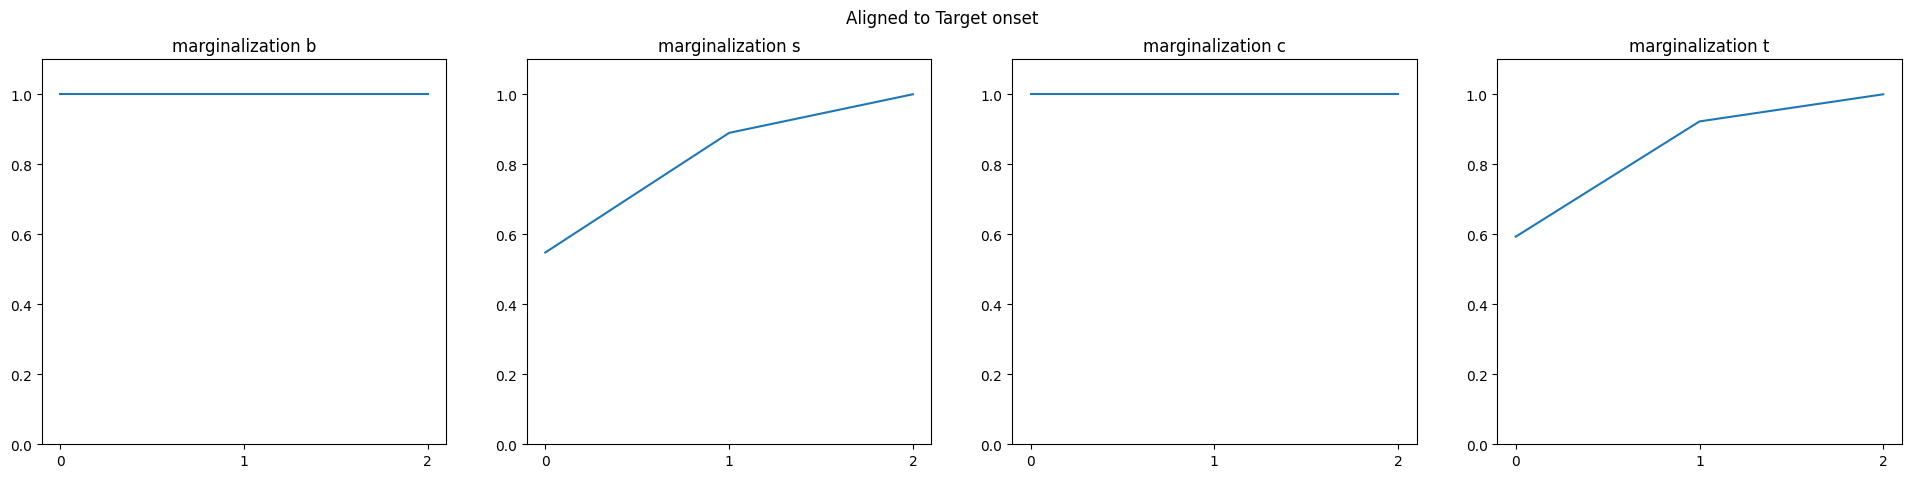

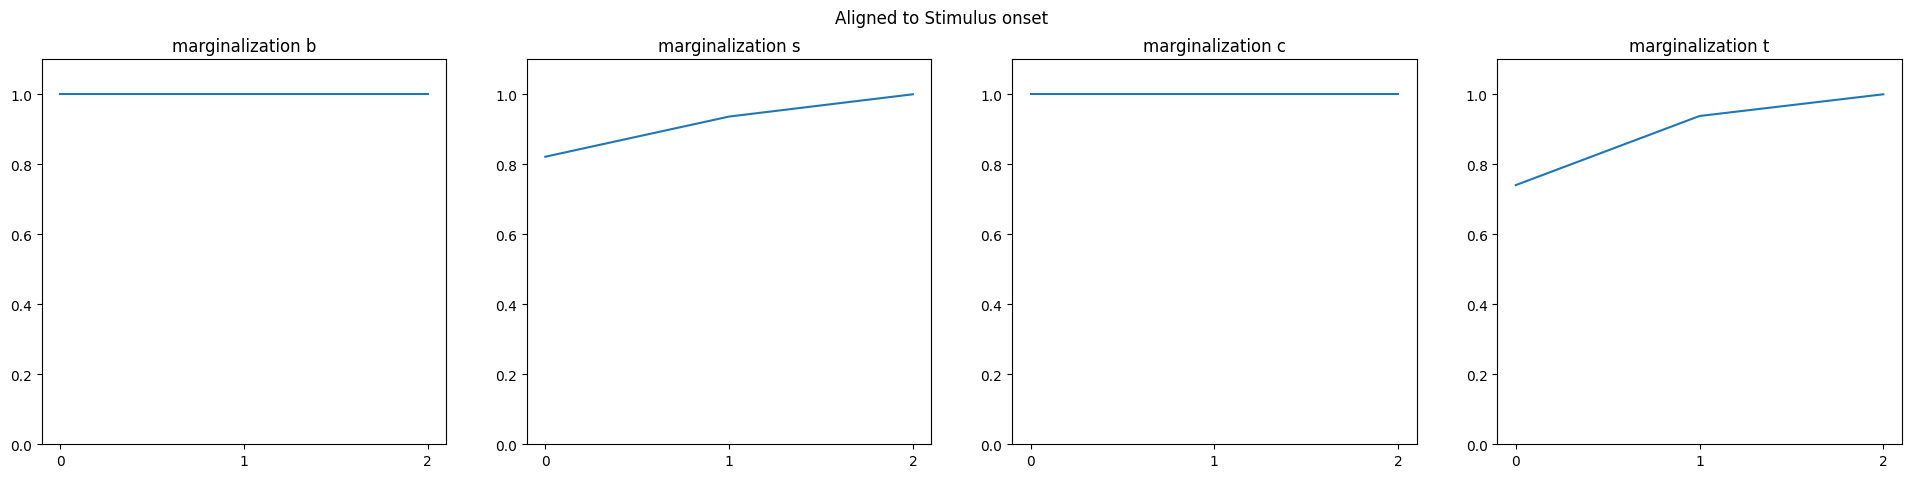

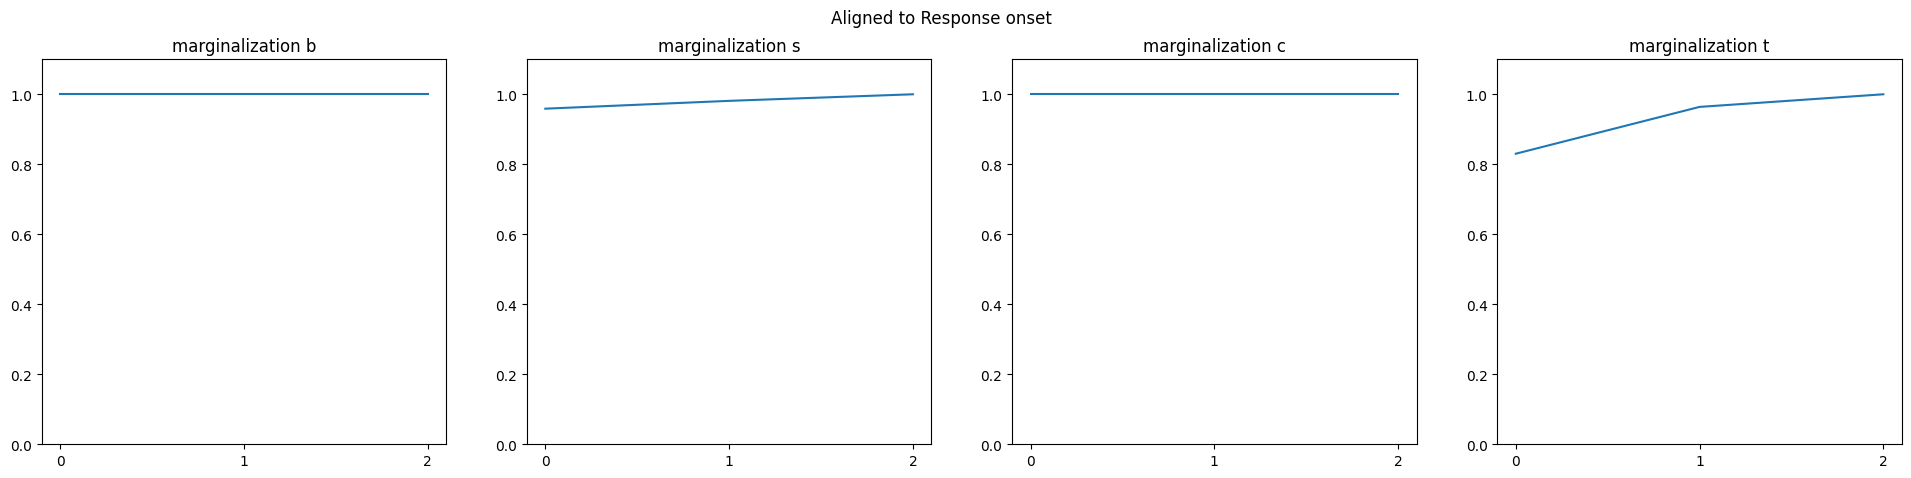

In [73]:
marginalization_keys = ['b', 's', 'c', 't']
for alignment in ephys_config["alignment_settings_GP"].keys():
    dpca = dpca_toRF_sessions[alignment]["model"]
    plt.figure(figsize=(24,5))
    for marg_idx, marginalization in enumerate(marginalization_keys):
        plt.subplot(1,len(marginalization_keys),marg_idx+1)
        plt.plot(np.cumsum(dpca.explained_variance_ratio_[marginalization])/np.sum(dpca.explained_variance_ratio_[marginalization]))
        plt.xticks(np.arange(n_components))
        plt.ylim([0,1.1])
        plt.title(f"marginalization {marginalization}")
    plt.suptitle(f"Aligned to {alignment.capitalize().replace('_', ' ')}")

### Significance Mask

In [133]:
significance_masks, true_score, scores = {},{},{}
for alignment in ephys_config["alignment_settings_GP"]:
    significance_masks[alignment], true_score[alignment], scores[alignment] = dpca_significance_analysis(
        dpca_toRF_sessions[alignment]["model"],dPCA_averaged_data[alignment], dPCA_trial_wise_data[alignment], n_shuffles=100,n_splits=100, axis=True, full=True)

Compute score of data:  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Finished.
Compute score of shuffled data:  99 / 100  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

#### plot dpca projection with significant bar

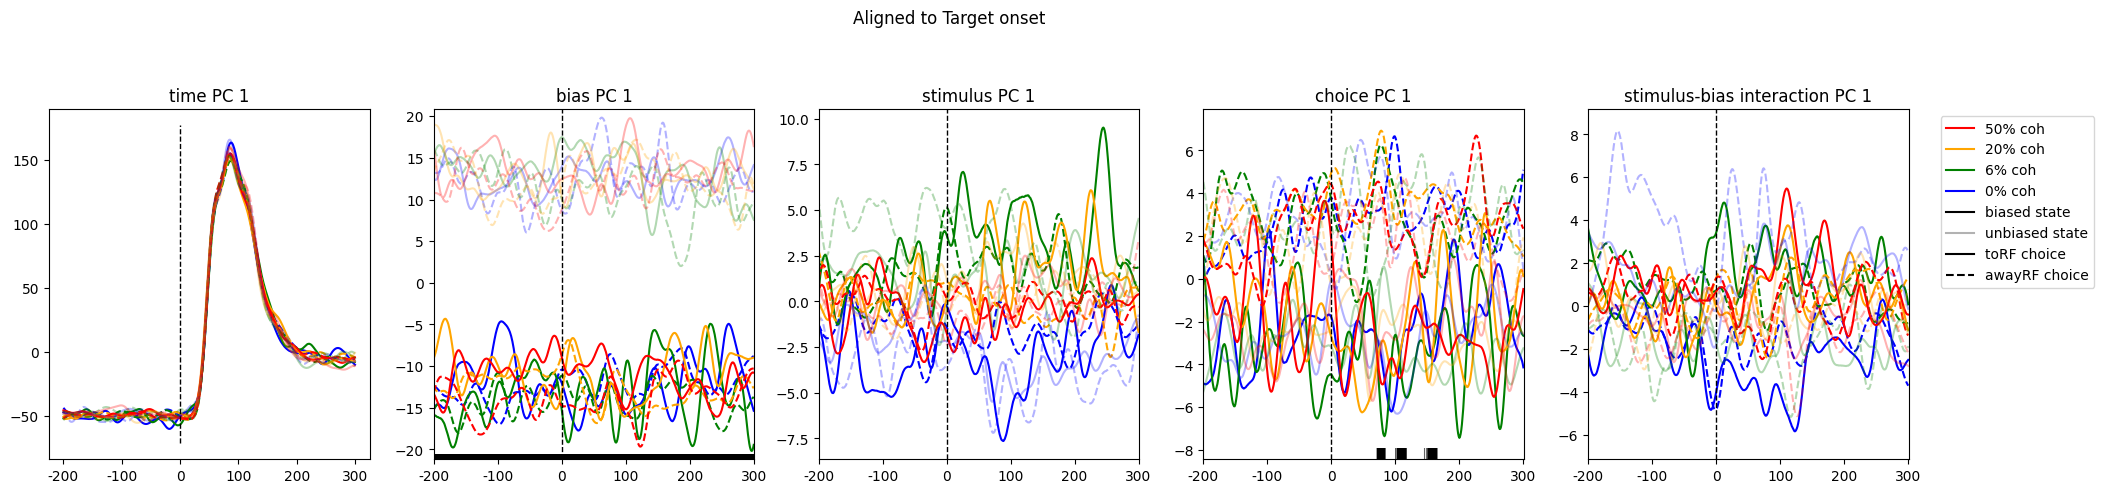

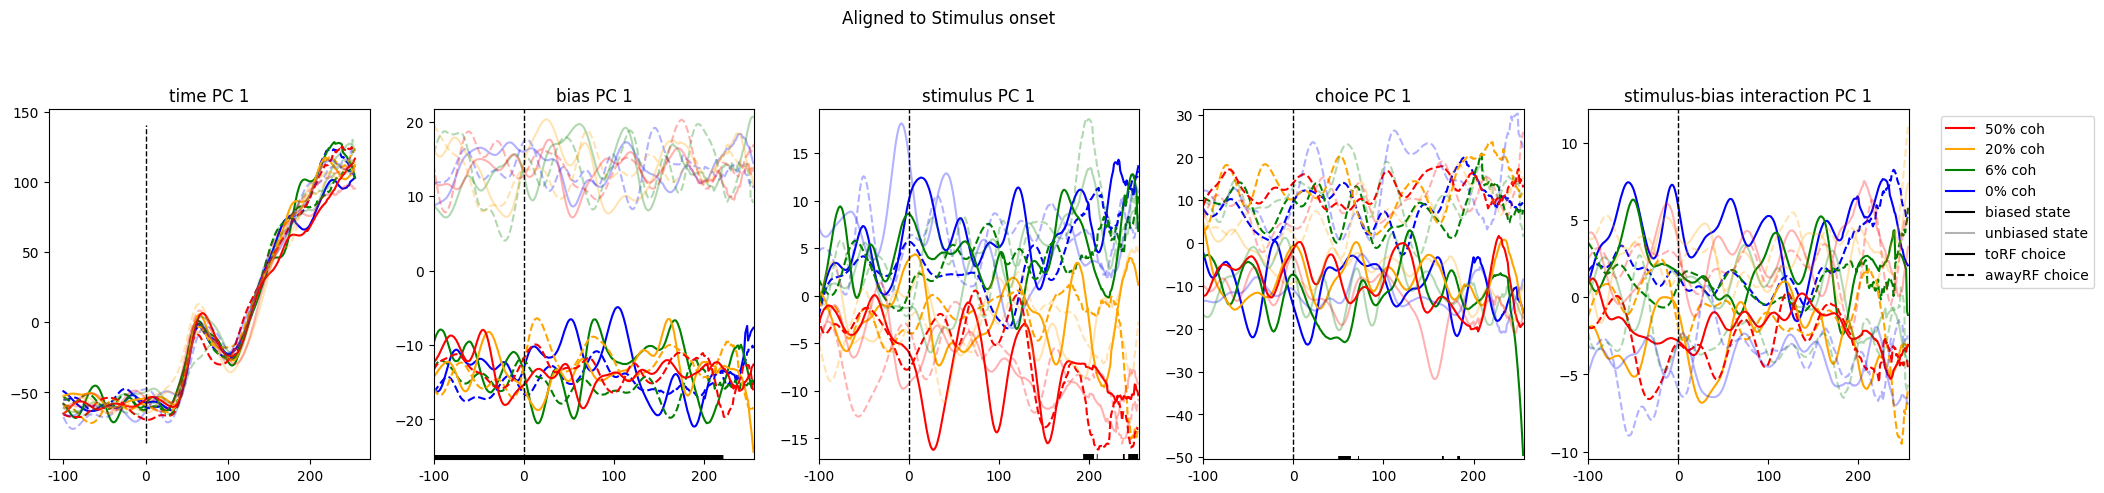

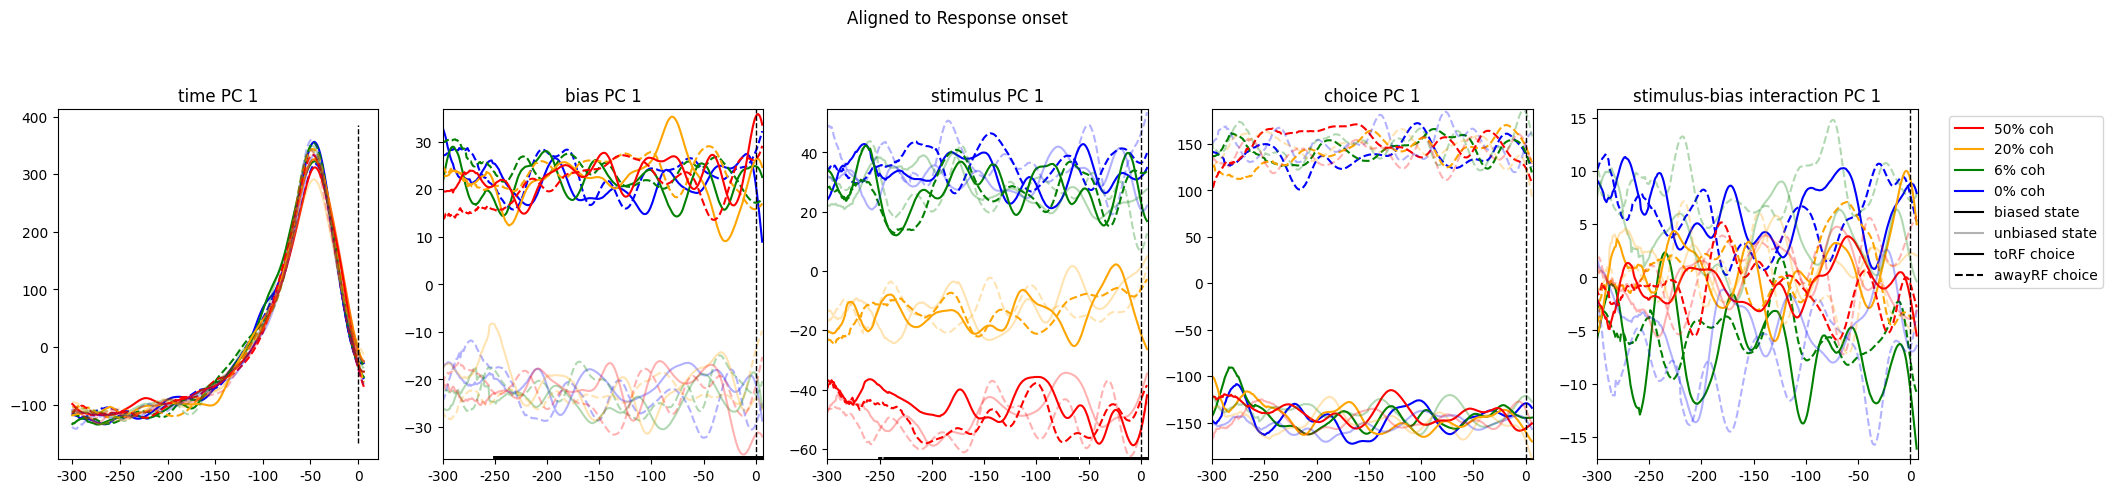

In [ ]:
plot_params = {"color":{0:"blue",1:"green",2:"orange",3:"red"},
               "lw":{0:2, 1:1},
               "linestyle":{0:"-",1:"--"},
               "opacity":{0:1, 1:0.3}}

for alignment in ephys_config["alignment_settings_GP"]:
    dpca = dpca_toRF_sessions[alignment]["model"]
    Z = dpca_toRF_sessions[alignment]["transformed_data"]

    alignment_dict = ephys_config["alignment_settings_GP"]
    time = np.arange(Z['t'].shape[-1])
    step = 50 if alignment == "response_onset" else 100


    plt.figure(figsize=(24,10))
    for PC_num in range(1):
        plt.subplot(2, 5, PC_num*5+1)

        for b in range(2):
            for s in range(4):
                for c in range(2):
                    plt.plot(time, Z['t'][PC_num, b, s ,c,:], color=plot_params["color"][s], alpha=plot_params["opacity"][b], linestyle=plot_params["linestyle"][c])
        
        plt.xticks(ticks=np.arange(0, alignment_dict[alignment]["end_time_ms"] - alignment_dict[alignment]["start_time_ms"] + 1, step),
                labels=np.arange(alignment_dict[alignment]["start_time_ms"], alignment_dict[alignment]["end_time_ms"]+ 1, step))
        ylim = plt.ylim()
        plt.vlines(-alignment_dict[alignment]["start_time_ms"], ylim[0], ylim[1], color="black", linestyle="--", linewidth=1)
        plt.title(f"time PC {PC_num+1}")


        plt.subplot(2, 5, PC_num*5+2)

        for b in range(2):
            for s in range(4):
                for c in range(2):
                    plt.plot(time, Z['b'][PC_num, b, s ,c,:], color=plot_params["color"][s], alpha=plot_params["opacity"][b], linestyle=plot_params["linestyle"][c])

        plt.imshow(significance_masks[alignment]['b'][PC_num][None,:],extent=[0,Z['t'].shape[-1],np.amin(Z['b'])-1,np.amin(Z['b'])-0.5],aspect='auto',cmap='gray_r',vmin=0,vmax=1)

        plt.title(f"bias PC {PC_num+1}")
        plt.xticks(ticks=np.arange(0, alignment_dict[alignment]["end_time_ms"] - alignment_dict[alignment]["start_time_ms"] + 1, step),
                labels=np.arange(alignment_dict[alignment]["start_time_ms"], alignment_dict[alignment]["end_time_ms"]+ 1, step))
        plt.ylim(np.amin(Z['b']) - 1, np.amax(Z['b']) + 1)
        plt.vlines(-alignment_dict[alignment]["start_time_ms"], *plt.ylim(), color="black", linestyle="--", linewidth=1)


        plt.subplot(2, 5, PC_num*5+3)
        for b in range(2):
            for s in range(4):
                for c in range(2):
                    plt.plot(time, Z['s'][PC_num, b, s ,c,:], color=plot_params["color"][s], alpha=plot_params["opacity"][b], linestyle=plot_params["linestyle"][c])
        plt.imshow(significance_masks[alignment]['s'][PC_num][None,:],extent=[0,Z['t'].shape[-1],np.amin(Z['s'])-1,np.amin(Z['s'])-0.5],aspect='auto',cmap='gray_r',vmin=0,vmax=1)

        plt.title(f"stimulus PC {PC_num+1}")
        plt.xticks(ticks=np.arange(0, alignment_dict[alignment]["end_time_ms"] - alignment_dict[alignment]["start_time_ms"] + 1, step),
                labels=np.arange(alignment_dict[alignment]["start_time_ms"], alignment_dict[alignment]["end_time_ms"]+ 1, step))
        plt.ylim(np.amin(Z['s']) - 1, np.amax(Z['s']) + 1)
        plt.vlines(-alignment_dict[alignment]["start_time_ms"], *plt.ylim(), color="black", linestyle="--", linewidth=1)

        plt.subplot(2, 5, PC_num*5+4)
        for b in range(2):
            for s in range(4):
                for c in range(2):
                    plt.plot(time, Z['c'][PC_num, b, s ,c,:], color=plot_params["color"][s], alpha=plot_params["opacity"][b], linestyle=plot_params["linestyle"][c])
        plt.imshow(significance_masks[alignment]['c'][PC_num][None,:],extent=[0,Z['t'].shape[-1],np.amin(Z['c'])-1,np.amin(Z['c'])-0.5],aspect='auto',cmap='gray_r',vmin=0,vmax=1)
        plt.title(f"choice PC {PC_num+1}")
        plt.xticks(ticks=np.arange(0, alignment_dict[alignment]["end_time_ms"] - alignment_dict[alignment]["start_time_ms"] + 1, step),
                labels=np.arange(alignment_dict[alignment]["start_time_ms"], alignment_dict[alignment]["end_time_ms"]+ 1, step))
        plt.ylim(np.amin(Z['c']) - 1, np.amax(Z['c']) + 1)
        plt.vlines(-alignment_dict[alignment]["start_time_ms"], *plt.ylim(), color="black", linestyle="--", linewidth=1)

        plt.subplot(2, 5, PC_num*5+5)
        for b in range(2):
            for s in range(4):
                for c in range(2):
                    plt.plot(time, Z['bs'][PC_num, b, s ,c,:], color=plot_params["color"][s], alpha=plot_params["opacity"][b], linestyle=plot_params["linestyle"][c])
        plt.imshow(significance_masks[alignment]['bs'][PC_num][None,:],extent=[0,Z['t'].shape[-1],np.amin(Z['bs'])-1,np.amin(Z['bs'])-0.5],aspect='auto',cmap='gray_r',vmin=0,vmax=1)
        plt.title(f"stimulus-bias interaction PC {PC_num+1}")
        plt.xticks(ticks=np.arange(0, alignment_dict[alignment]["end_time_ms"] - alignment_dict[alignment]["start_time_ms"] + 1, step),
                labels=np.arange(alignment_dict[alignment]["start_time_ms"], alignment_dict[alignment]["end_time_ms"]+ 1, step))
        plt.ylim(np.amin(Z['bs']) - 1, np.amax(Z['bs']) + 1)
        plt.vlines(-alignment_dict[alignment]["start_time_ms"], *plt.ylim(), color="black", linestyle="--", linewidth=1)



    plt.plot([],[], color="red", label="50% coh")
    plt.plot([],[], color="orange", label="20% coh")
    plt.plot([],[], color="green", label="6% coh")
    plt.plot([],[], color="blue", label="0% coh")
    plt.plot([],[], color='k', alpha=1, label="biased state")
    plt.plot([],[], color='k', alpha=0.3, label="unbiased state")
    plt.plot([],[], color='k', linestyle="-", label="toRF choice")
    plt.plot([],[], color='k', linestyle="--", label="awayRF choice")
    plt.legend(bbox_to_anchor=(1.6, 1), loc='upper right')
    plt.suptitle(f"Aligned to {alignment.capitalize().replace('_', ' ')}")
    plt.show()

#### plot shuffled projection

In [ ]:
mean_shuffled_Z = {}
for alignment in ephys_config["alignment_settings_GP"].keys():
    _,mean_shuffled_Z[alignment] = dpca_shuffle(dpca_toRF_sessions[alignment]["model"], dPCA_trial_wise_data[alignment],n_shuffles=100)

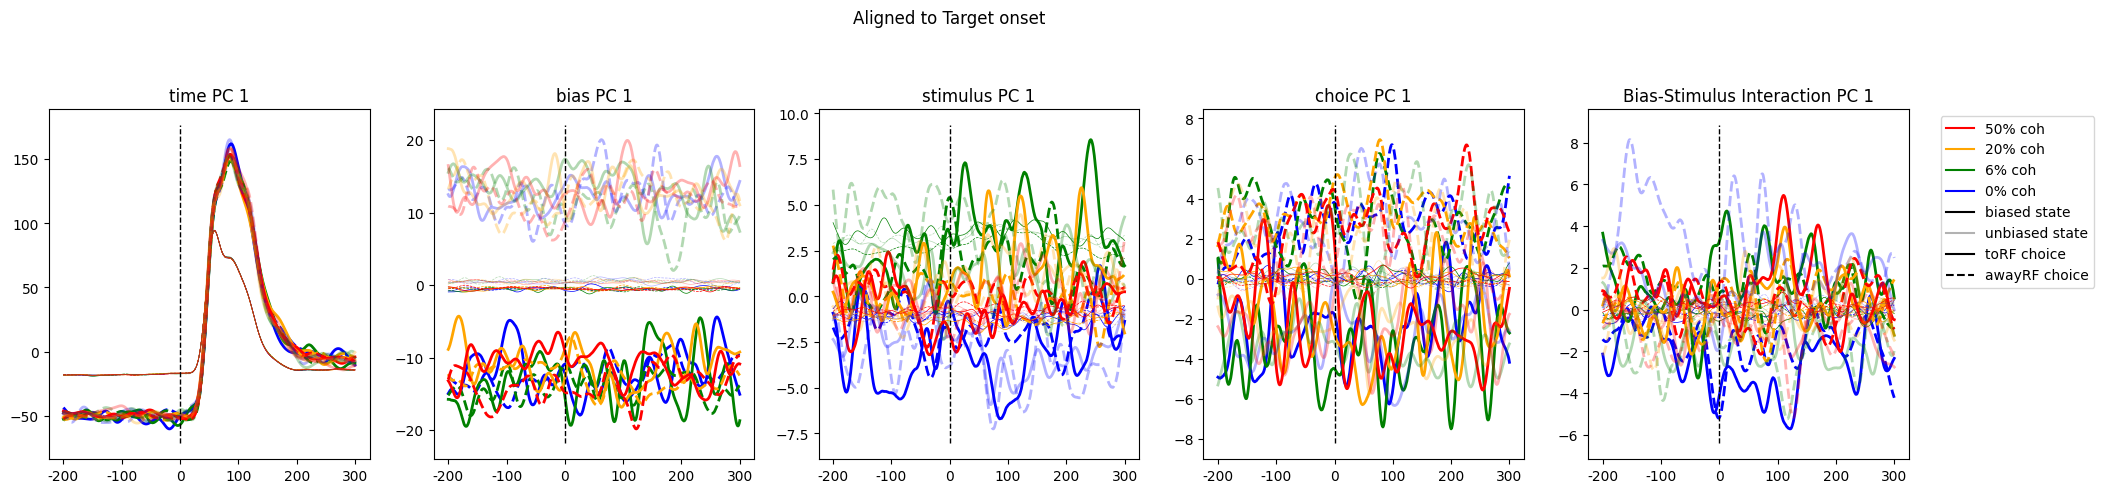

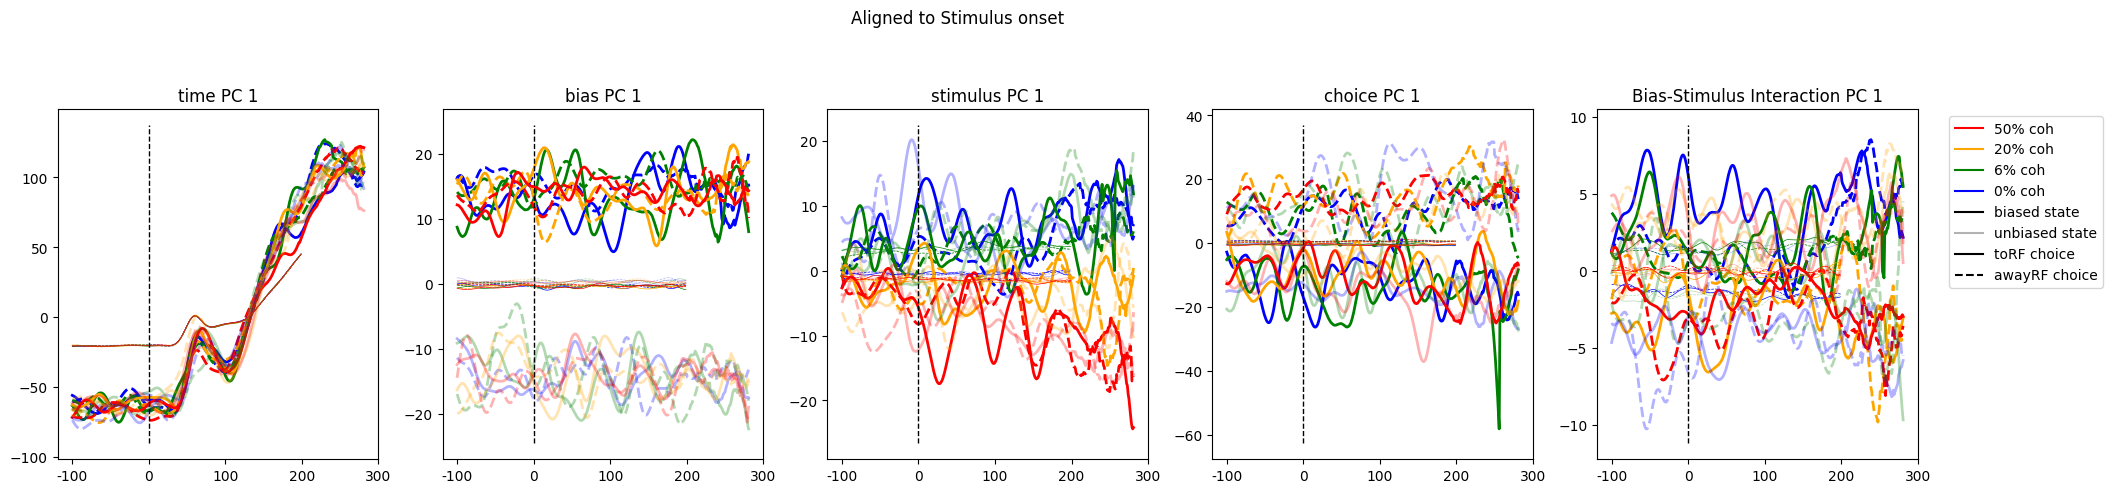

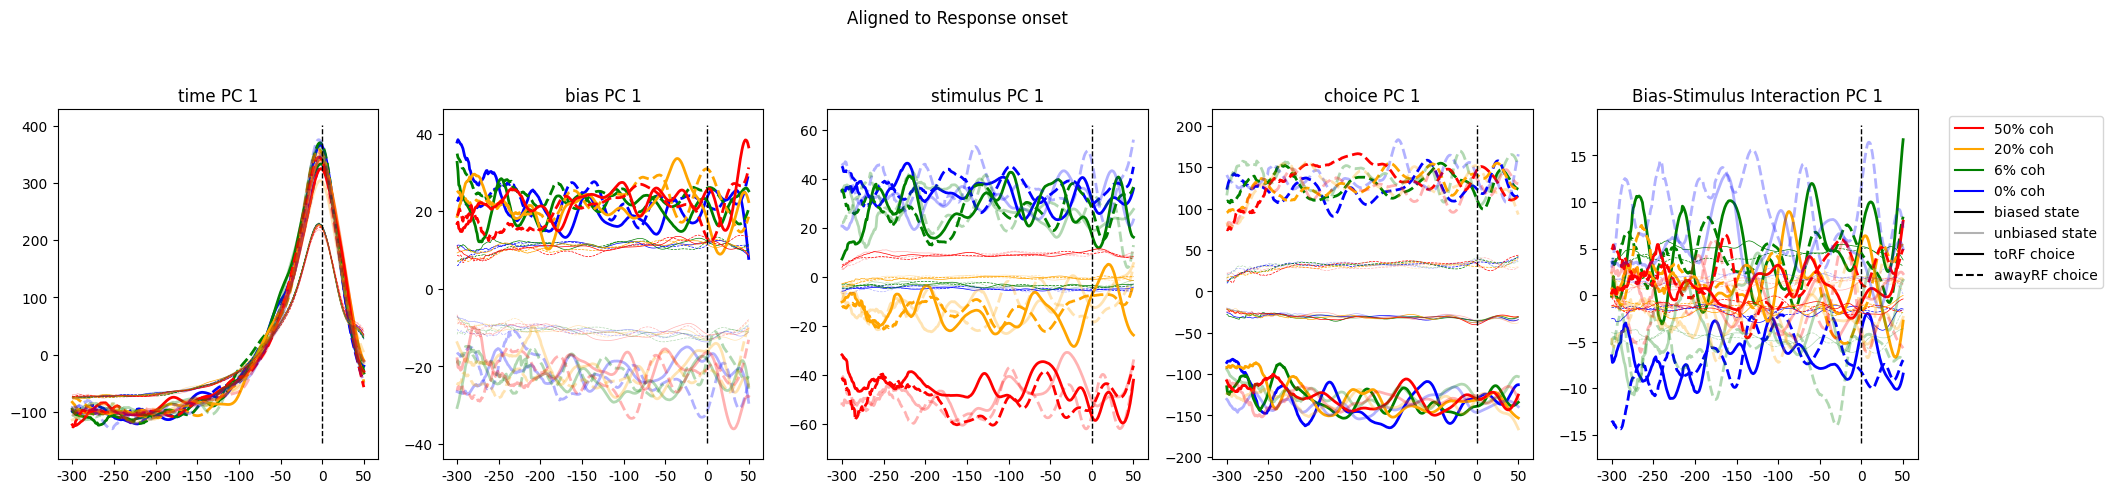

In [198]:
plot_params = {"color":{0:"blue",1:"green",2:"orange",3:"red"},
               "lw":{0:2, 1:1},
               "linestyle":{0:"-",1:"--"},
               "opacity":{0:1, 1:0.3}}
lw, lw_shuffle = 2,0.5

for alignment in ephys_config["alignment_settings_GP"].keys():
    shuffled_Z = mean_shuffled_Z[alignment]
    Z = dpca_toRF_sessions[alignment]["transformed_data"]
    alignment_dict = ephys_config["alignment_settings_GP"]
    step = 50 if alignment == "response_onset" else 100

    plt.figure(figsize=(24,10))
    for PC_num in range(1):
        plt.subplot(2, 5, PC_num*5+1)

        for b in range(2):
            for s in range(4):
                for c in range(2):
                    plt.plot(range(Z['t'].shape[4]), Z['t'][PC_num, b, s ,c,:], color=plot_params["color"][s], alpha=plot_params["opacity"][b], linestyle=plot_params["linestyle"][c], linewidth = lw)
                    plt.plot(range(shuffled_Z['t'].shape[4]), shuffled_Z['t'][PC_num, b, s ,c,:], color=plot_params["color"][s], alpha=plot_params["opacity"][b], linestyle=plot_params["linestyle"][c], linewidth = lw_shuffle)
        plt.xticks(ticks=np.arange(0, alignment_dict[alignment]["end_time_ms"] - alignment_dict[alignment]["start_time_ms"] + 1, step),
                labels=np.arange(alignment_dict[alignment]["start_time_ms"], alignment_dict[alignment]["end_time_ms"]+ 1, step))
        ylim = plt.ylim()
        plt.vlines(-alignment_dict[alignment]["start_time_ms"], ylim[0], ylim[1], color="black", linestyle="--", linewidth=1)
        plt.title(f"time PC {PC_num+1}")


        plt.subplot(2, 5, PC_num*5+2)

        for b in range(2):
            for s in range(4):
                for c in range(2):
                    plt.plot(range(Z['t'].shape[4]), Z['b'][PC_num, b, s ,c,:], color=plot_params["color"][s], alpha=plot_params["opacity"][b], linestyle=plot_params["linestyle"][c], linewidth = lw)
                    plt.plot(range(shuffled_Z['t'].shape[4]), shuffled_Z['b'][PC_num, b, s ,c,:], color=plot_params["color"][s], alpha=plot_params["opacity"][b], linestyle=plot_params["linestyle"][c], linewidth = lw_shuffle)
        plt.title(f"bias PC {PC_num+1}")
        plt.xticks(ticks=np.arange(0, alignment_dict[alignment]["end_time_ms"] - alignment_dict[alignment]["start_time_ms"] + 1, step),
                labels=np.arange(alignment_dict[alignment]["start_time_ms"], alignment_dict[alignment]["end_time_ms"]+ 1, step))
        ylim = plt.ylim()
        plt.vlines(-alignment_dict[alignment]["start_time_ms"], ylim[0], ylim[1], color="black", linestyle="--", linewidth=1)

        plt.subplot(2, 5, PC_num*5+3)
        for b in range(2):
            for s in range(4):
                for c in range(2):
                    plt.plot(range(Z['t'].shape[4]), Z['s'][PC_num, b, s ,c,:], color=plot_params["color"][s], alpha=plot_params["opacity"][b], linestyle=plot_params["linestyle"][c], linewidth = lw)
                    plt.plot(range(shuffled_Z['t'].shape[4]), shuffled_Z['s'][PC_num, b, s ,c,:], color=plot_params["color"][s], alpha=plot_params["opacity"][b], linestyle=plot_params["linestyle"][c], linewidth = lw_shuffle)
        plt.title(f"stimulus PC {PC_num+1}")
        plt.xticks(ticks=np.arange(0, alignment_dict[alignment]["end_time_ms"] - alignment_dict[alignment]["start_time_ms"] + 1, step),
                labels=np.arange(alignment_dict[alignment]["start_time_ms"], alignment_dict[alignment]["end_time_ms"]+ 1, step))
        ylim = plt.ylim()
        plt.vlines(-alignment_dict[alignment]["start_time_ms"], ylim[0], ylim[1], color="black", linestyle="--", linewidth=1)

        plt.subplot(2, 5, PC_num*5+4)
        for b in range(2):
            for s in range(4):
                for c in range(2):
                    plt.plot(range(Z['t'].shape[4]), Z['c'][PC_num, b, s ,c,:], color=plot_params["color"][s], alpha=plot_params["opacity"][b], linestyle=plot_params["linestyle"][c], linewidth = lw)
                    plt.plot(range(shuffled_Z['t'].shape[4]), shuffled_Z['c'][PC_num, b, s ,c,:], color=plot_params["color"][s], alpha=plot_params["opacity"][b], linestyle=plot_params["linestyle"][c], linewidth = lw_shuffle)
        plt.title(f"choice PC {PC_num+1}")
        plt.xticks(ticks=np.arange(0, alignment_dict[alignment]["end_time_ms"] - alignment_dict[alignment]["start_time_ms"] + 1, step),
                labels=np.arange(alignment_dict[alignment]["start_time_ms"], alignment_dict[alignment]["end_time_ms"]+ 1, step))
        ylim = plt.ylim()
        plt.vlines(-alignment_dict[alignment]["start_time_ms"], ylim[0], ylim[1], color="black", linestyle="--", linewidth=1)


        plt.subplot(2, 5, PC_num*5+5)
        for b in range(2):
            for s in range(4):
                for c in range(2):
                    plt.plot(range(Z['t'].shape[4]), Z['bs'][PC_num, b, s ,c,:], color=plot_params["color"][s], alpha=plot_params["opacity"][b], linestyle=plot_params["linestyle"][c], linewidth = lw)
                    plt.plot(range(shuffled_Z['t'].shape[4]), shuffled_Z['bs'][PC_num, b, s ,c,:], color=plot_params["color"][s], alpha=plot_params["opacity"][b], linestyle=plot_params["linestyle"][c], linewidth = lw_shuffle)
        plt.title(f"Bias-Stimulus Interaction PC {PC_num+1}")
        plt.xticks(ticks=np.arange(0, alignment_dict[alignment]["end_time_ms"] - alignment_dict[alignment]["start_time_ms"] + 1, step),
                labels=np.arange(alignment_dict[alignment]["start_time_ms"], alignment_dict[alignment]["end_time_ms"]+ 1, step))
        ylim = plt.ylim()
        plt.vlines(-alignment_dict[alignment]["start_time_ms"], ylim[0], ylim[1], color="black", linestyle="--", linewidth=1)

    plt.plot([],[], color="red", label="50% coh")
    plt.plot([],[], color="orange", label="20% coh")
    plt.plot([],[], color="green", label="6% coh")
    plt.plot([],[], color="blue", label="0% coh")
    plt.plot([],[], color='k', alpha=1, label="biased state")
    plt.plot([],[], color='k', alpha=0.3, label="unbiased state")
    plt.plot([],[], color='k', linestyle="-", label="toRF choice")
    plt.plot([],[], color='k', linestyle="--", label="awayRF choice")
    plt.legend(bbox_to_anchor=(1.6, 1), loc='upper right')
    plt.suptitle(f"Aligned to {alignment.capitalize().replace('_', ' ')}")
    plt.show()

### project demixed PCs on PCA

### Transform on full ephys data